# Transfer Learning

In the Previous Excersise we generated an upgraded model with Hyper parameter tunning that had this characteristics:



In [3]:
# import the model best_image_classification_model.h5
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import sys

# load the model
model = load_model('best_image_classification_model.h5')

# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2368      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 128)       18560     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 37, 37, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 18, 18, 256)      

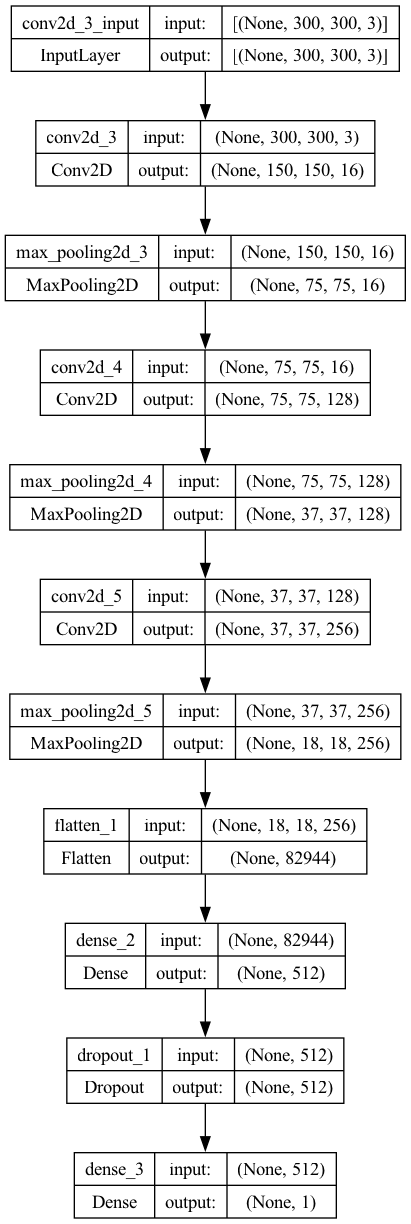

In [4]:
#Import tf
import tensorflow as tf

# Visualize the model using graphviz
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set test directory and image size (based on your model's input size)
test_dir = 'Pictures/test'  # Replace with your test directory
image_size = (300, 300)  # Replace with the input size expected by your model

# Data generator for test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values to [0,1]

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important: Keep shuffle=False for confusion matrix to work
)

# Mapping class indices (optional: to print the actual label names)
class_indices = test_generator.class_indices
print(class_indices)  # {'def_front': 0, 'ok_front': 1}  # This is an example

Found 715 images belonging to 2 classes.
{'def_front': 0, 'ok_front': 1}


In [12]:
# Make predictions
preds = model.predict(test_generator)
preds = (preds > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Get the true labels
true_labels = test_generator.classes  # True labels of the test data

23/23 [==============================] - 1s 62ms/step


In [13]:
# print how many images where predicted
print(f"Number of images predicted: {len(preds)}")


Number of images predicted: 715


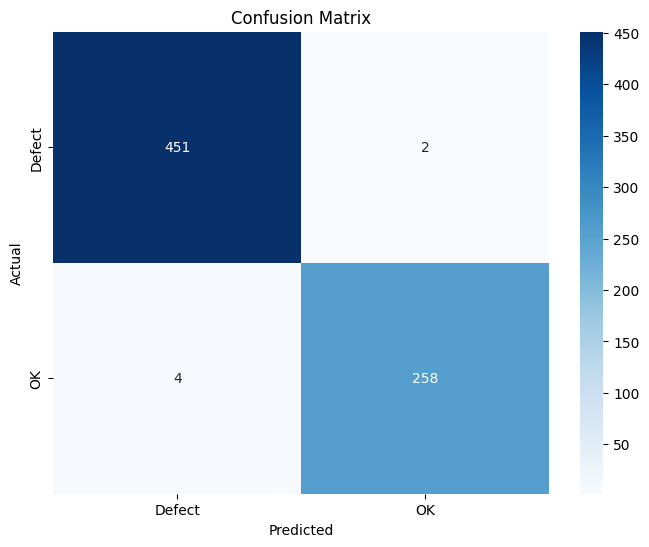

              precision    recall  f1-score   support

      Defect       0.99      1.00      0.99       453
          OK       0.99      0.98      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [14]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Defect', 'OK'], yticklabels=['Defect', 'OK'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed performance metrics
print(classification_report(true_labels, preds, target_names=['Defect', 'OK']))

## Accuracy of the model was: 98.88% 

Let's see what can be done to improve the model with transfer learning

# Transfer Learning

## Train Keras VGG16 model from Skratch using my Training Pictures

I chose to use VGG16 for transfer learning in my application for detecting OK and defective parts because it has been pre-trained on the ImageNet dataset, which consists of over 14 million images across 1,000 categories.
 VGG16 has a total of 16 layers, and in my model, I’m using its first 13 convolutional layers as a feature extractor.
 By leveraging these pre-trained layers, I can take advantage of VGG16's ability to recognize complex patterns such as edges and textures, which helps in distinguishing between OK and defective parts efficiently. 
 This approach reduces the need for large amounts of data and significantly speeds up training time.

In my implementation, I froze the 13 convolutional layers of VGG16 to retain the knowledge it gained from ImageNet, and I added custom dense and dropout layers on top to tailor the model specifically to my task.
This combination allows the model to focus on features relevant to my dataset while preventing overfitting. 
The ability to use VGG16's layers ensures a strong foundation for accurate predictions, while the custom layers ensure the model adapts to my specific problem.

By using transfer learning, I avoid the challenges of building a model from scratch, such as slow convergence and overfitting, especially with a limited dataset.
 VGG16's pre-trained layers make it ideal for tasks like mine, where subtle defects need to be detected quickly and accurately.
  Fine-tuning is always an option if I need to improve performance further, making VGG16 a flexible and powerful tool for real-world applications like defect detection in manufacturing.

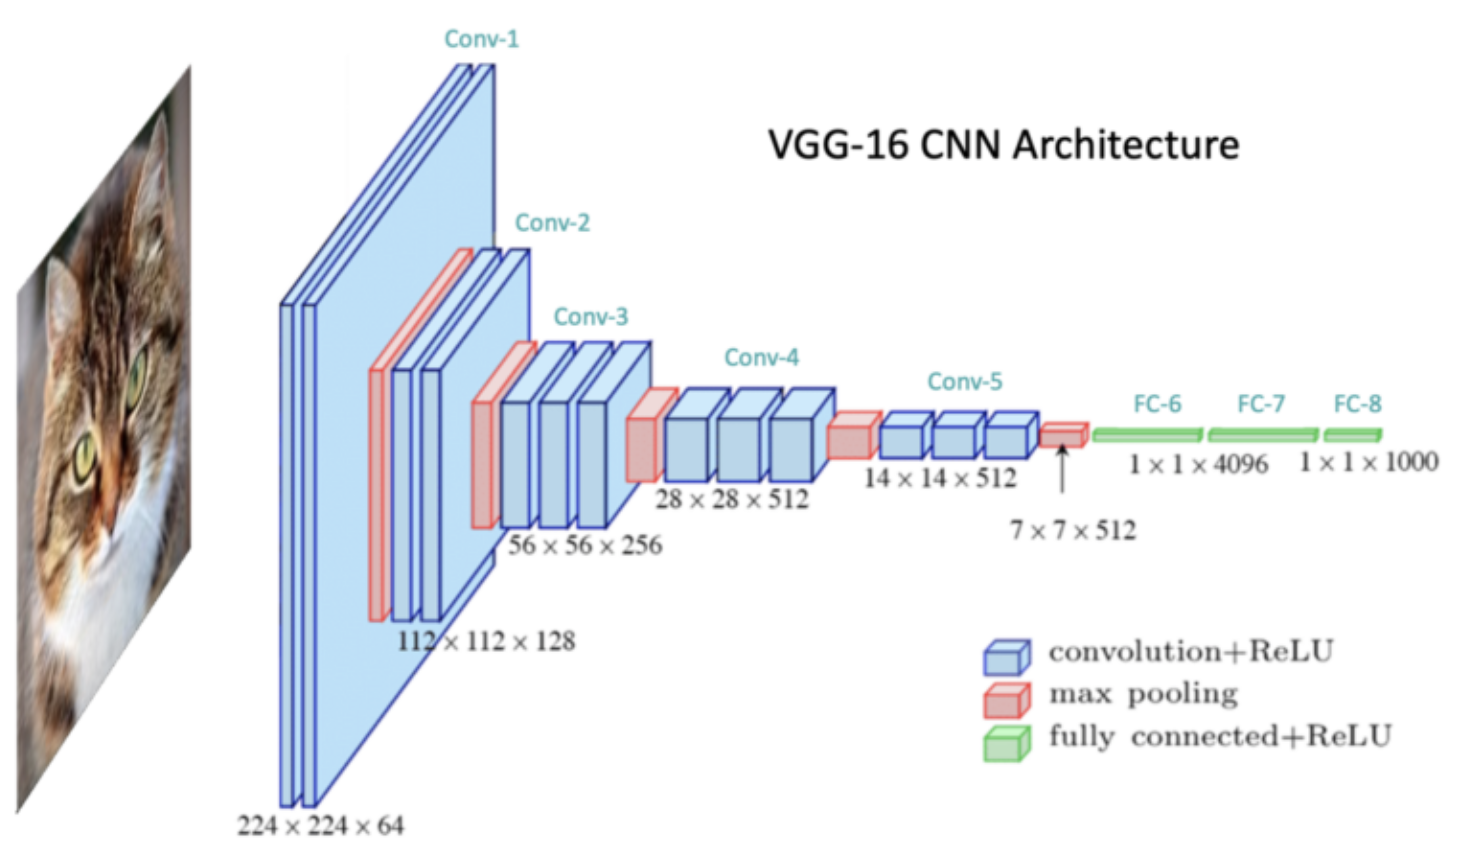

In [16]:
from keras.models import load_model, Sequential
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

# Load a pre-trained model: VGG16 without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze the pre-trained model's layers so they aren't retrained initially
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the pre-trained model as the base
transfer_model = Sequential()

# Add the pre-trained base model
transfer_model.add(base_model)

# Add a Flatten layer to flatten the output from the pre-trained model
transfer_model.add(Flatten())

# Add Dense layers (similar to my existing model)
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(1, activation='sigmoid'))

# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
transfer_model.summary()

58889256/58889256 [==============================] - 5s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 512)               21234176  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 35949377 (137.14 MB)
Trainable params: 21234689 (81.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Train the Keras VGG16:

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Data generators for training and testing data
train_dir = "Pictures/train"
test_dir = "Pictures/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = transfer_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop]
)

# Evaluate the model
test_loss, test_accuracy = transfer_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 7487 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Epoch 1/10
234/234 [==============================] - 477s 2s/step - loss: 0.5017 - accuracy: 0.7711 - val_loss: 0.2010 - val_accuracy: 0.9455
Epoch 2/10
234/234 [==============================] - 510s 2s/step - loss: 0.2284 - accuracy: 0.9193 - val_loss: 0.0969 - val_accuracy: 0.9888
Epoch 3/10
234/234 [==============================] - 496s 2s/step - loss: 0.1477 - accuracy: 0.9545 - val_loss: 0.0776 - val_accuracy: 0.9888
Epoch 4/10
234/234 [==============================] - 494s 2s/step - loss: 0.1141 - accuracy: 0.9671 - val_loss: 0.0512 - val_accuracy: 0.9916
Epoch 5/10
234/234 [==============================] - 472s 2s/step - loss: 0.1078 - accuracy: 0.9662 - val_loss: 0.0524 - val_accuracy: 0.9902
Epoch 6/10
234/234 [==============================] - 470s 2s/step - loss: 0.0900 - accuracy: 0.9729 - val_loss: 0.0368 - val_accuracy: 0.9930
Epoch 7/10
234/234 [==============================] - 467s 

# Nice! 99.3% Accuracy!

## Unfreeze some layers for fine tunning to see if the model can be further improved

In [18]:
# Unfreeze the last 4 layers of VGG16 for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
transfer_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = transfer_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
234/234 [==============================] - 552s 2s/step - loss: 0.0609 - accuracy: 0.9821 - val_loss: 0.0363 - val_accuracy: 0.9930
Epoch 2/10
228/234 [============================>.] - ETA: 13s - loss: 0.0420 - accuracy: 0.9857

2024-09-08 17:48:54.794794: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'Pictures/train/def_front/cast_def_0_1776.jpeg'
Traceback (most recent call last):

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter

230/234 [============================>.] - ETA: 8s - loss: 0.0418 - accuracy: 0.9859 

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: 'Pictures/train/def_front/cast_def_0_1776.jpeg'
Traceback (most recent call last):

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/Users/javie/Library/Python/3.9/lib/python/site-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: 'Pictures/train/def_front/cast_def_0_1776.jpeg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_14905]